In [1]:
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy as scipy
from tqdm import tqdm
from scipy.sparse import csr_matrix
from pandas.api.types import CategoricalDtype

from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split,cross_val_score, StratifiedKFold, GridSearchCV, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score

from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB


from sklearn.metrics import plot_confusion_matrix

In [2]:
df = pd.read_csv("/Users/samholt/GA/DSI12-lessons/projects/Capstone_Project/Capstone_MKII_DataProcessed.csv'")

In [3]:
#set index to unnamed
df.drop("Unnamed: 0", axis= 1, inplace= True)

In [4]:
df.head()

,iphone,news,gaming,DestinyTheGame,MonsterHunter,single_user_subreddits,The_Donald,NoStupidQuestions,Stims,nba,...,AskReddit,FortNiteBR,CircleofTrust,Showerthoughts,fo76,BrandNewSentence,inthesoulstone,pokemongotrades,PushaT,df_target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Columns: 501 entries, iphone to df_target
dtypes: float64(501)
memory usage: 305.8 MB


#### Proof of Concept modelling
* Testing models on sampled data ahead of porting to AWS for greater computational power
* Creating class function to assess various resampling methods on our data

In [6]:
# split sample into target and predictor variables
y = df.pop("df_target").to_numpy()
X = df

X
len(y)

80000

In [7]:
# create train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify= y, random_state=13)

# standardize data, maxabsscaler as to work on sparse data 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
# create dataframe to track params & scoring
cols = ["phase", "model_type", "cv_score", "training_score", "precision", "recall", "f1-score", "TP", "FP", "TN", "FN"]
model_tracker = pd.DataFrame(columns= cols)

In [9]:
model_tracker

,phase,model_type,cv_score,training_score,precision,recall,f1-score,TP,FP,TN,FN


In [10]:
#create function to run different models
def model_run(model):
    """returns average score, training score, class report metrics and confusion matrix outputs"""
    scores = cross_val_score(model, X_train, y_train, cv=5)
    # get cross val score
    scores = cross_val_score(model, X_train, y_train, cv=5)

    # get training score
    model.fit(X_train, y_train)
    training_score = model.score(X_train, y_train)

    # predict and get classification report & confusion matrix info
    predictions = model.predict(X_test)
    class_report = classification_report(y_test, predictions, output_dict= True)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    
    print("Model run complete")
    return scores, training_score, class_report, tn, fp, fn, tp

In [11]:
# logistic regression, base model
model = LogisticRegression(class_weight= "balanced", solver = "sag", max_iter= 8000)

scores, training_score, class_report, tn, fp, fn, tp = model_run(model)

# append to model tracker
results = pd.Series(["PoC", "log_reg", scores.mean(), training_score, class_report["1.0"]["precision"], class_report["1.0"]["recall"], class_report["1.0"]["f1-score"],tp, fp, tn, fn], index= model_tracker.columns)
model_tracker = model_tracker.append(results, ignore_index= True)

Model run complete


In [12]:
# KNN, base model
model = KNeighborsClassifier()

scores, training_score, class_report, tn, fp, fn, tp = model_run(model)

results = pd.Series(["PoC", "KNN", scores.mean(), training_score, class_report["1.0"]["precision"], class_report["1.0"]["recall"], class_report["1.0"]["f1-score"],tp, fp, tn, fn], index= model_tracker.columns)
model_tracker = model_tracker.append(results, ignore_index= True)

Model run complete


In [13]:
# Decision tree, base model
model = DecisionTreeClassifier(min_samples_split= 50)

scores, training_score, class_report, tn, fp, fn, tp = model_run(model)

results = pd.Series(["PoC", "D_Tree", scores.mean(), training_score, class_report["1.0"]["precision"], class_report["1.0"]["recall"], class_report["1.0"]["f1-score"],tp, fp, tn, fn], index= model_tracker.columns)
model_tracker = model_tracker.append(results, ignore_index= True)

Model run complete


In [14]:
# Random forest, basic model
model = RandomForestClassifier(n_estimators= 100, n_jobs= 2)

scores, training_score, class_report, tn, fp, fn, tp = model_run(model)

results = pd.Series(["PoC", "Rand_Fr", scores.mean(), training_score, class_report["1.0"]["precision"], class_report["1.0"]["recall"], class_report["1.0"]["f1-score"],tp, fp, tn, fn], index= model_tracker.columns)
model_tracker = model_tracker.append(results, ignore_index= True)

Model run complete


In [15]:
# Gradient boost, basic model
model = model = GradientBoostingClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=1)

scores, training_score, class_report, tn, fp, fn, tp = model_run(model)

results = pd.Series(["PoC", "Grad_Bst", scores.mean(), training_score, class_report["1.0"]["precision"], class_report["1.0"]["recall"], class_report["1.0"]["f1-score"],tp, fp, tn, fn], index= model_tracker.columns)
model_tracker = model_tracker.append(results, ignore_index= True)

Model run complete


In [20]:
# Linear SVC, basic model
model = LinearSVC()

scores, training_score, class_report, tn, fp, fn, tp = model_run(model)

results = pd.Series(["PoC", "SVC", scores.mean(), training_score, class_report["1.0"]["precision"], class_report["1.0"]["recall"], class_report["1.0"]["f1-score"],tp, fp, tn, fn], index= model_tracker.columns)
model_tracker = model_tracker.append(results, ignore_index= True)

/Users/samholt/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/samholt/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/samholt/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/samholt/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/samholt/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to c

Model run complete


In [21]:
model_tracker

,phase,model_type,cv_score,training_score,precision,recall,f1-score,TP,FP,TN,FN
0,PoC,log_reg,0.859857,0.866929,0.198923,0.551453,0.292378,702,2827,19900,571
1,PoC,KNN,0.945982,0.951446,0.420382,0.051846,0.092308,66,91,22636,1207
2,PoC,D_Tree,0.936821,0.969321,0.313869,0.168892,0.219612,215,470,22257,1058
3,PoC,Rand_Fr,0.949250,0.999000,0.665094,0.110762,0.189899,141,71,22656,1132
4,PoC,Grad_Bst,0.948286,0.951268,0.606299,0.060487,0.110000,77,50,22677,1196
5,PoC,SVC,0.945929,0.946982,0.476658,0.152396,0.230952,194,213,22514,1079


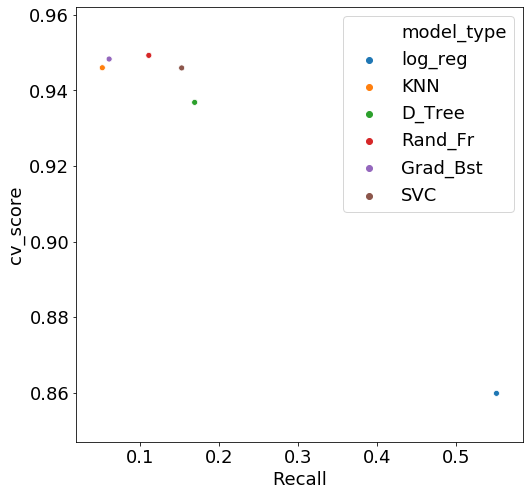

In [24]:
# Visualisation of accuracy vs. recall for these models show a distinct trade-off, the model(s) to
# take forward are the ones which minimize the accuracy recall trade-off

plt.figure(figsize=(8, 8))
plt.rcParams.update({'font.size': 18})
sns.scatterplot(model_tracker["recall"], model_tracker["cv_score"], hue= model_tracker["model_type"])

plt.xlabel("Recall")
plt.ylabel("cv_score")
plt.show()

#### Assess Optimal Sampling Technique with Various Models
* To improve the models in terms of identifying the minority class, several under and oversampling methodologies were applied to the training set


In [10]:
from imblearn.under_sampling import (RandomUnderSampler, 
                                     ClusterCentroids,
                                     TomekLinks,
                                     NeighbourhoodCleaningRule,
                                     NearMiss)
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN

In [11]:
# create dataframe to track params & scoring
cols = ["Model", "Method", "cv_score", "training_score", "accuracy", "precision", "recall", "f1-score", "TP", "FP", "TN", "FN"]
model_tracker = pd.DataFrame(columns= cols)

In [12]:
# creating class called tiny target which will evaluate several different sampling techniques on a user selected model
class tiny_target:
    def __init__(self, X, y, scaler= MaxAbsScaler(), model= LogisticRegression(), sampling_strategy= 0.5, train_size = 0.3, run_all = True, cv_scoring = "recall", stratify = y, cv= 5, tracker = None, name = "model"):
        if tracker is not None:
            self.tracker = tracker
        else:
            cols = ["Model", "Method", "cv_score", "training_score", "accuracy", "precision", "recall", "f1-score", "TP", "FP", "TN", "FN"]
            model_tracker = pd.DataFrame(columns= cols)
            self.tracker = model_tracker
            
        self.X = X
        self.y = y
        self.model = model
        self.sampling_strategy = sampling_strategy
        self.train_size = train_size
        self.stratify = stratify
        self.cv = cv
        self.name = name
        self.cv_scoring = cv_scoring
        self.tracker = tracker
    
    def model_runner(self):
        """runs models and appends various scoring metrics (y target focused) to model tracker"""
        self.model.fit(self.X_train_new, self.y_train_new)
        self.scores = cross_val_score(self.model, self.X_train_new, self.y_train_new, cv= self.cv, scoring = self.cv_scoring)
        self.training_score = self.model.score(self.X_train_new, self.y_train_new)

        # predict and get classification report & confusion matrix info
        self.predictions = self.model.predict(self.X_test)
        self.class_report = classification_report(self.y_test, self.predictions, output_dict= True)
        self.tn, self.fp, self.fn, self.tp = confusion_matrix(self.y_test, self.predictions).ravel()
        
        self.model_tracker()
        
    def model_tracker(self):
        self.results = pd.DataFrame({'Model': self.name, 'Method': self.method, 'cv_score': self.scores.mean(), 
                                'training_score': self.training_score,'accuracy': self.class_report["accuracy"],
                                'precision': self.class_report["1.0"]["precision"], 'recall': self.class_report["1.0"]["recall"],
                                'f1-score': self.class_report["1.0"]["f1-score"], 'TP': self.tp, 'FP': self.fp,
                                'TN': self.tn, 'FN': self.fn}, index=[len(model_tracker.index)])
        self.tracker =  pd.concat([self.tracker, self.results])
    
    def run_all(self):
        self.random_under()
        
        self.tomeklinks()
        self.neighbourhoodclean()
        self.nearmiss()
        self.smote_upsample()
        self.random_over()
        self.adasyn()
        return self.tracker
    
    def random_under(self):
        """Randomly undersamples the predictor class. Can lead to loss of information 
        unless the majority class is relatively uniform"""
        
        self.sampler = RandomUnderSampler(sampling_strategy= self.sampling_strategy, random_state= 13)
        
        self.X_train, self.X_test, self.y_train , self.y_test = train_test_split( \
            self.X, self.y, train_size=self.train_size, stratify=self.stratify, random_state=13)
        self.X_train_new, self.y_train_new = self.sampler.fit_resample(self.X_train, self.y_train)
        self.method = "Random Under"
        self.model_runner() 
        print("Random undersample run complete")
        return self.tracker
    
    def clustercentroids(self):
        """This method undersamples the majority class by replacing a cluster of majority samples. 
        Clusters of majority class found with K-mean algorithms. Then it keeps the cluster centroids of the 
        N clusters as the new majority samples"""
        self.sampler = ClusterCentroids(sampling_strategy= self.sampling_strategy, random_state= 13)
        
        self.X_train, self.X_test, self.y_train , self.y_test = train_test_split(self.X, self.y, train_size=self.train_size, stratify=self.stratify, random_state=13)
        self.X_train_new, self.y_train_new = self.sampler.fit_resample(self.X_train, self.y_train)
        self.method = "Cluster Centroids"
        self.model_runner()
        
        print("Cluster centroids run complete")
        return self.tracker
    
    def tomeklinks(self):
        """Finds samples near the borderline of the two classess. Given two instances, a & b seperated by distance
        d(a,b) the pair is called a Tomek link if there is no instance c such that d(a,c) < d(a,b) or d(b,c) < d(a,b)
        Instances within Tomek links are considered noise or borderline and are thus removed"""
        
        self.sampler = TomekLinks()
        
        self.X_train, self.X_test, self.y_train , self.y_test = train_test_split(self.X, self.y, train_size=self.train_size, stratify=self.stratify, random_state=13)
        self.X_train_new, self.y_train_new = self.sampler.fit_resample(self.X_train, self.y_train)
        self.method = "Tomek Links"
        self.model_runner()
        
        print("TomekLinks run complete")
        return self.tracker
    
    def neighbourhoodclean(self):
        """ Edited Nearest Neighbor Rule (ENN) to remove any instance whose class label is different from the class
        of at least two of its three nearest neighbors. Neighbourhood cleaning rule uses ENN to remove majority samples
        Finds three nearest neighbors for each training set instance, if majority class and opposite to its neighbours 
        it is removed. If belongs to the target class than the neighbours are removed"""
        
        self.sampler = NeighbourhoodCleaningRule()
        
        self.X_train, self.X_test, self.y_train , self.y_test = train_test_split(self.X, self.y, train_size=self.train_size, stratify=self.stratify, random_state=13)
        self.X_train_new, self.y_train_new = self.sampler.fit_resample(self.X_train, self.y_train)
        self.method = "Neighbourhood Clean"
        self.model_runner()
        
        print("Neighbourhood Cleaning run complete")
        return self.tracker
    
    def nearmiss(self):
        """Calculates distances between all instance of majority and minority classes. K instances of the majority
        class with smallest distances to minority are selected and removed"""
        
        self.sampler = NearMiss(sampling_strategy= self.sampling_strategy)
        
        self.X_train, self.X_test, self.y_train , self.y_test = train_test_split(self.X, self.y, train_size=self.train_size, stratify=self.stratify, random_state=13)
        self.X_train_new, self.y_train_new = self.sampler.fit_resample(self.X_train, self.y_train)
        self.method = "Near Miss"
        self.model_runner()
       
        print("Near Miss run complete")
        return self.tracker
        
    
    def smote_upsample(self, k_neighbors = 5):
        self.k_neighbors = k_neighbors
        self.sampler = SMOTE(sampling_strategy= self.sampling_strategy, random_state= 13, k_neighbors= self.k_neighbors)
        self.X_train, self.X_test, self.y_train , self.y_test = train_test_split(self.X, self.y, train_size=self.train_size, stratify=self.stratify, random_state=13)

        cv = KFold(n_splits=5, shuffle = True)
        self.scores = np.array([])
        for train_fold_index, val_fold_index in cv.split(self.X_train, self.y_train):
         
             # Get the training data
            X_train_fold, y_train_fold = self.X_train.iloc[train_fold_index], self.y_train[train_fold_index]
        # Get the validation data
            X_val_fold, y_val_fold = self.X_train.iloc[val_fold_index], self.y_train[val_fold_index]

        # Upsample only the data in the training section
            X_train_fold_upsample, y_train_fold_upsample = self.sampler.fit_resample(X_train_fold,
                                                                           y_train_fold)
            model_obj = self.model.fit(X_train_fold_upsample, y_train_fold_upsample)
            score = recall_score(y_val_fold, model_obj.predict(X_val_fold))
            self.scores = np.append(self.scores, score)  
        
        self.X_train_new, self.y_train_new = self.sampler.fit_resample(self.X_train, self.y_train)
        self.model.fit(self.X_train_new, self.y_train_new)
        self.training_score = self.model.score(self.X_train_new, self.y_train_new)

        # predict and get classification report & confusion matrix info
        self.predictions = self.model.predict(self.X_test)
        self.class_report = classification_report(self.y_test, self.predictions, output_dict= True)
        self.tn, self.fp, self.fn, self.tp = confusion_matrix(self.y_test, self.predictions).ravel()
        self.method = "SMOTE"
        self.model_tracker()
        
        print("SMOTE run complete")
        return self.tracker
    
    def random_over(self):
        self.sampler = RandomOverSampler(sampling_strategy= self.sampling_strategy, random_state= 13)
        self.X_train, self.X_test, self.y_train , self.y_test = train_test_split(self.X, self.y, train_size=self.train_size, stratify=self.stratify, random_state=13)

        cv = KFold(n_splits=5, shuffle = True)
        self.scores = np.array([])
        for train_fold_index, val_fold_index in cv.split(self.X_train, self.y_train):
         
             # Get the training data
            X_train_fold, y_train_fold = self.X_train.iloc[train_fold_index], self.y_train[train_fold_index]
        # Get the validation data
            X_val_fold, y_val_fold = self.X_train.iloc[val_fold_index], self.y_train[val_fold_index]

        # Upsample only the data in the training section
            X_train_fold_upsample, y_train_fold_upsample = self.sampler.fit_resample(X_train_fold,
                                                                           y_train_fold)
            model_obj = self.model.fit(X_train_fold_upsample, y_train_fold_upsample)
            score = recall_score(y_val_fold, model_obj.predict(X_val_fold))
            self.scores = np.append(self.scores, score)  
        
        self.X_train_new, self.y_train_new = self.sampler.fit_resample(self.X_train, self.y_train)
        self.model.fit(self.X_train_new, self.y_train_new)
        self.training_score = self.model.score(self.X_train_new, self.y_train_new)
      

        # predict and get classification report & confusion matrix info
        self.predictions = self.model.predict(self.X_test)
        self.class_report = classification_report(self.y_test, self.predictions, output_dict= True)
        self.tn, self.fp, self.fn, self.tp = confusion_matrix(self.y_test, self.predictions).ravel()
        self.method = "Random oversample"
        self.model_tracker()
        
        print("Random oversample run complete")
        return self.tracker
        

        
    def adasyn(self, n_neighbors = 5):
        self.n_neighbors = n_neighbors
        self.sampler = ADASYN(sampling_strategy= self.sampling_strategy, random_state= 13, n_neighbors= self.n_neighbors)
        self.X_train, self.X_test, self.y_train , self.y_test = train_test_split(self.X, self.y, train_size=self.train_size, stratify=self.stratify, random_state=13)

        cv = KFold(n_splits=5, shuffle = True)
        self.scores = np.array([])
        for train_fold_index, val_fold_index in cv.split(self.X_train, self.y_train):
         
             # Get the training data
            X_train_fold, y_train_fold = self.X_train.iloc[train_fold_index], self.y_train[train_fold_index]
        # Get the validation data
            X_val_fold, y_val_fold = self.X_train.iloc[val_fold_index], self.y_train[val_fold_index]

        # Upsample only the data in the training section
            X_train_fold_upsample, y_train_fold_upsample = self.sampler.fit_resample(X_train_fold,
                                                                           y_train_fold)
            model_obj = self.model.fit(X_train_fold_upsample, y_train_fold_upsample)
            score = recall_score(y_val_fold, model_obj.predict(X_val_fold))
            self.scores = np.append(self.scores, score)  
        
        self.X_train_new, self.y_train_new = self.sampler.fit_resample(self.X_train, self.y_train)
        self.model.fit(self.X_train_new, self.y_train_new)
        self.training_score = self.model.score(self.X_train_new, self.y_train_new)

        # predict and get classification report & confusion matrix info
        self.predictions = self.model.predict(self.X_test)
        self.class_report = classification_report(self.y_test, self.predictions, output_dict= True)
        self.tn, self.fp, self.fn, self.tp = confusion_matrix(self.y_test, self.predictions).ravel()
        self.method = "ADASYN"
        self.model_tracker()
        
        print("ADASYN run complete")
        return self.tracker
        

#### Prioritising for Recall

In [13]:
# create dataframe to track params & scoring
cols = ["Model", "Method", "cv_score", "training_score", "accuracy", "precision", "recall", "f1-score", "TP", "FP", "TN", "FN"]
model_tracker = pd.DataFrame(columns= cols)

In [14]:
model_tracker

,Model,Method,cv_score,training_score,accuracy,precision,recall,f1-score,TP,FP,TN,FN


In [15]:
y[10000]

0.0

In [ ]:
# fit log reg instance of tiny target
tt = tiny_target(X,y, model= LogisticRegression(solver = "sag", max_iter = 10000), tracker = model_tracker, name = "log_reg")
model_tracker = model_tracker.append(tt.run_all())

Random undersample run complete


In [ ]:
# fit KNN instance of tiny target
tt = tiny_target(X,y, model= KNeighborsClassifier(), tracker = model_tracker, name = "KNN")
model_tracker = model_tracker.append(tt.run_all())

In [ ]:
# fit decision tree instance of tiny target
tt = tiny_target(X,y, model= DecisionTreeClassifier(min_samples_split= 50), tracker = model_tracker, name = "Dec_Tree")
model_tracker = model_tracker.append(tt.run_all())

In [ ]:
# fit random forest instance of tiny target
tt = tiny_target(X,y, model= RandomForestClassifier(n_estimators= 100, n_jobs= 2), tracker = model_tracker, name = "Ran_FR")
model_tracker = model_tracker.append(tt.run_all())

In [ ]:
# fit grad boost instance of tiny target
tt = tiny_target(X,y, model= GradientBoostingClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=1), tracker = model_tracker, name = "GB")
model_tracker = model_tracker.append(tt.run_all())

In [ ]:
model_tracker.to_csv("/Users/samholt/GA/DSI12-lessons/projects/Capstone_Project/Capstone_MKII_Model_tracker.csv'")

In [ ]:
model_tracker.sort_values(by = "recall", ascending= False)

In [ ]:
# Visualisation of accuracy vs. recall for these models show a distinct trade-off, the model(s) to
# take forward are the ones which minimize the accuracy recall trade-off

plt.figure(figsize=(8, 8))
plt.rcParams.update({'font.size': 18})
sns.scatterplot(model_tracker["recall"], model_tracker["accuracy"], hue= model_tracker["Model"])

plt.xlabel("Recall")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
#select models which maximize both accuracy & recall, defined as 80% accuracy and 50% recall
model_tracker[(model_tracker["recall"] > 0.49) & (model_tracker["accuracy"] > 0.79)][["Model", "Method", "accuracy", "recall"]]

#### Gridsearch & Optimize Best Model
* Due to time constraints one logistic regression model was taken forward for analysis & gridsearch on the full dataset
* Gridsearching based on our best model, logistic regression combined with random undersampling
* Random undersampling loses a lot of data so we are using the model on the full sparse DF

In [ ]:
# split sample into target and predictor variables
X = sparse_df[:,:-1]
y = sparse_df[:, -1].toarray().ravel()

X
len(y)

In [ ]:
# fit sampler

sampler = RandomUnderSampler(sampling_strategy= 0.5, random_state= 13)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.3, stratify = y, random_state = 13)

X_train_new, y_train_new = sampler.fit_resample(X_train, y_train)

In [ ]:
model = LogisticRegression(solver = "sag", max_iter = 10000)
params = {'C':[0.001, 0.01, 1, 10,25],
          'fit_intercept': [True, False]}

model_GS = GridSearchCV(estimator=model,
                param_grid=params,
                cv=5,
                scoring='recall',
                return_train_score=True, verbose= 2)

In [ ]:
# fit model and assess classification report
model_GS.fit(X_train_new,y_train_new)
print("Baseline testing score was: {}".format(str(baseline)))
print("Logistic regression best mean cross val score was: {}".format(str(cross_val_score(model_GS, X_train_new, y_train_new, cv=5).mean())))
print("Logistic regression best training score was : {}".format(str(model_GS.score(X_train_new, y_train_new))))
predictions = model_GS.predict(X_test)


In [ ]:
print(classification_report(y_test, predictions))

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))

plot_confusion_matrix(model_GS,X_test, y_test, ax = ax, values_format="")
plt.ylim()
plt.show()

In [ ]:
# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(model_GS.best_estimator_.coef_, columns= unique_subs[:-1],
                       index=['coefficients'])
# calculate the absolute values of the coefficients
df_coef = df_coef.T
df_coef['coef_abs'] = df_coef.coefficients.abs()
df_coef.sort_values(by = "coef_abs", ascending = False).head(5)

In [ ]:
f, ax = plt.subplots(figsize = (8, 13))
df_coef['coef_abs'].sort_values(ascending = False).head(15).plot(kind='barh');
plt.show()

## Summary & Next Steps
* Overall the evaluated models offer potential for identifying mental health risk in internet forum users
* In particular, the greatest potential use case is likely to be identifying users who may not currently be aware of, and post to, support forums but who could benefit from their supports & thus promotion on over popular subreddits
* The high recall at the expense at accuracy is too much in some cases, though a high number of false positives is not as much of an issue for a risk analyses, and indeed may reflect current sufferers of mental health issues who simply do not post to reddit about their issues
* Their are some potential risks & limitations for this research:
    * The demographic used in the sample is likely to be younger & focused on North America & Europe 
    * The majority of users on any website are ‘lurkers’ and do not post, this research assumes that they are represented & do not differ significantly in personality etc. than those who do post
    * Key assumption is that posting on mental health forums is indicative of mental health risk 
* Next steps would include:
    * Grid Searching & fine tuning remaining models
    * Expanding data set to incorporate additional years for greater breadth of sample
    * Network analysis to flesh out those subreddits most closely related to mental health 
